##FACIAL EMOTION DETECTION##

importing the libraries

In [ ]:
import pandas as pd
import numpy as np
import sys, os
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Flatten,Dense,Activation,Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.utils import np_utils

##importing the dataset##

In [ ]:
data= pd.read_csv('/content/drive/MyDrive/Emotion recognition/fer2013.csv')
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
np.sort(data['emotion'].unique())

array([0, 1, 2, 3, 4, 5, 6])

##0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral##

In [ ]:
data['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

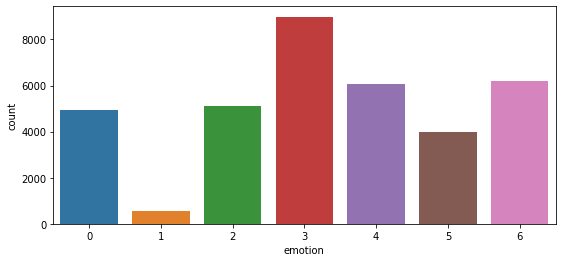

In [ ]:
plt.figure(figsize=(9,4))
sns.countplot(x='emotion', data=data)

In [ ]:
print(data["Usage"].value_counts())

Training       28709
PublicTest      3589
PrivateTest     3589
Name: Usage, dtype: int64


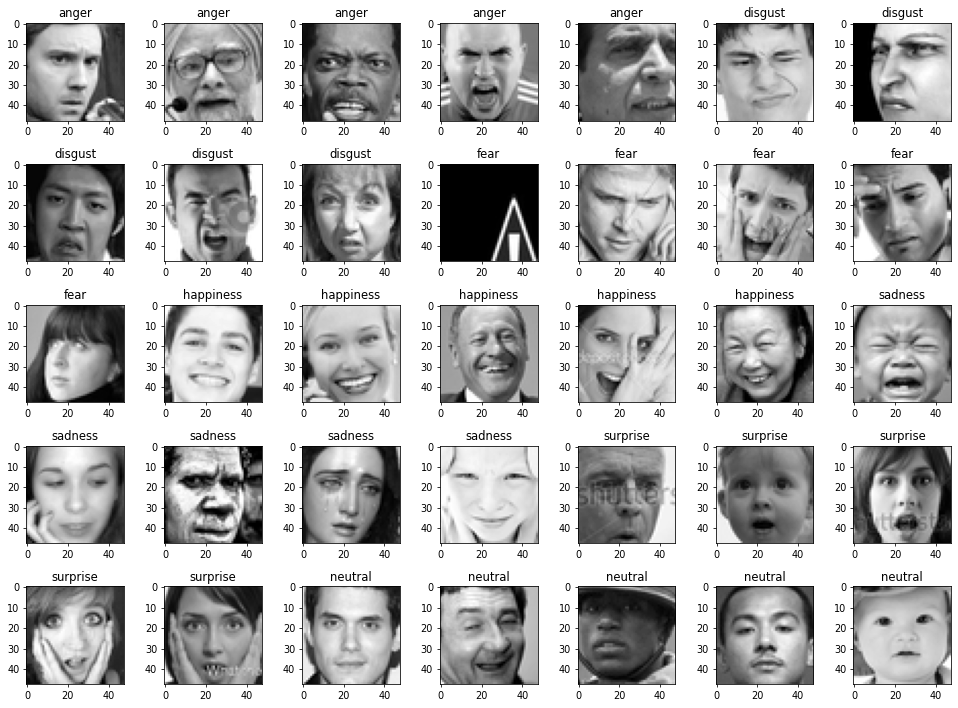

In [ ]:
emotion_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}
fig = plt.figure(figsize=(14,14),dpi=70)
k = 0
for num in sorted(data.emotion.unique()):
    for j in range(5):
        px = data[data.emotion==num].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_title(emotion_text[num])
        plt.tight_layout()

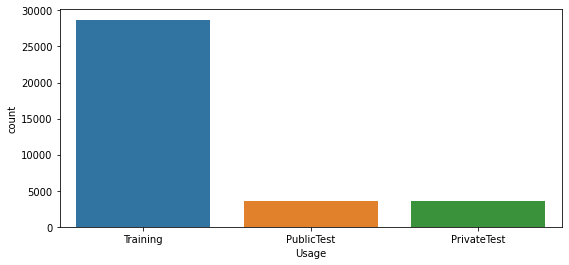

In [ ]:
plt.figure(figsize=(9,4))
sns.countplot(x='Usage', data=data)

In [ ]:
data.info() ##checking for any null values and the datatype of the variable

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


##splitting the data into train and test datasets##

In [ ]:
X_train, y_train, X_test, y_test= [],[],[],[]
##iterating over rows to find the index series pair
for index, row in data.iterrows():
    val=row['pixels'].split(" ")
    try:
        if 'Training' in row['Usage']:
           X_train.append(np.array(val,'float32'))
           y_train.append(row['emotion'])
        elif 'PublicTest' in row['Usage']:
           X_test.append(np.array(val,'float32'))
           y_test.append(row['emotion'])
    except:
        print(f"error occured at index :{index} and row:{row}")







In [ ]:
X_train[0:2],y_train[0:2],X_test[0:2],y_test[0:2]

([array([ 70.,  80.,  82., ..., 106., 109.,  82.], dtype=float32),
  array([151., 150., 147., ..., 193., 183., 184.], dtype=float32)],
 [0, 0],
 [array([254., 254., 254., ...,  42., 129., 180.], dtype=float32),
  array([156., 184., 198., ..., 172., 167., 161.], dtype=float32)],
 [0, 1])

##now we need to convert these train and test lists to arrays because keras will only accept no.arrays as input##

In [ ]:
X_train= np.array(X_train,'float32')
y_train= np.array(y_train,'float32')
X_test= np.array(X_test,'float32')
y_test= np.array(y_test,'float32')
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((28709, 2304), (28709,), (3589, 2304), (3589,))

In [ ]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 200
width, height = 48, 48
y_train=np_utils.to_categorical(y_train, num_classes=num_labels)
y_test=np_utils.to_categorical(y_test, num_classes=num_labels)

##normalizing the data using z-score normalization##

In [ ]:
X_train -= np.mean(X_train, axis=0)
X_train /= np.std(X_train, axis=0)
X_test -= np.mean(X_test, axis=0)
X_test /= np.std(X_test, axis=0)

now we need to reshape our train and test sets in a format that the keras will accept

In [ ]:
X_train = X_train.reshape(X_train.shape[0], width, height, 1)
X_test = X_test.reshape(X_test.shape[0], width, height, 1) ##1 means that the 1 image we feed will have height and width 48x48
X_train.shape


(28709, 48, 48, 1)

##DESIGNING THE CONVOLUTION NEURAL NETWORK(CNN)##

We are using the Sequential model as it has one input and one output structure

In [ ]:
model= Sequential()
##1st CONVOLUTIONAL LAYER
model.add(Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=(X_train.shape[1:]))) ## 64 defines that we are using 64 filers of size 3,3 with the activation= relu(to ensure non linearity ie convert the negative numbers from feature map to 0)
model.add(Conv2D(64,kernel_size= (3, 3), activation='relu',padding='same'))
model.add(BatchNormalization())   #used to stabilise perhaps accelerate learning process
## now we add the POOLING layer ie the maxpooling layer of size 2,2 with the stride 2,2
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5)) # will randomly drop some neurons from the layers to prevent overfitting

#2nd CONVOLUTIONAL LAYER
model.add(Conv2D(64,kernel_size= (3, 3), activation='relu'))
model.add(Conv2D(64,kernel_size= (3, 3), activation='relu'))
model.add(BatchNormalization())
#adding pooling layer
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))

#3rd CONVOLUTIONAL LAYER
model.add(Conv2D(128,kernel_size= (3, 3), activation='relu'))
model.add(Conv2D(128,kernel_size= (3, 3), activation='relu'))
model.add(BatchNormalization())
#adding pooling layer
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.5))


#ADDDING THE FLATTEN LAYER
#this layer will convert our data into simple 1-d array for inputting it to the next layer
model.add(Flatten())
#ADDING DENSE/FULLY CONNECTED LAYER
#full connection bw layers
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.6))
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.6))

model.add(Dense(num_labels, activation='softmax'))
model.summary()


Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_91 (Conv2D)           (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_56 (Batc (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_71 (Dropout)         (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 21, 21, 64)        36928     
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 19, 19, 64)      

##DATA AUGMENTATION##

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
data_generator = ImageDataGenerator(featurewise_center=False, featurewise_std_normalization=False,rotation_range=10,width_shift_range=0.1,
                                    height_shift_range=0.1,zoom_range=.1,horizontal_flip=True)

##COMPILING THE MODEL##

In [ ]:
model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])
model.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_91 (Conv2D)           (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization_56 (Batc (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
dropout_71 (Dropout)         (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_93 (Conv2D)           (None, 21, 21, 64)        36928     
_________________________________________________________________
conv2d_94 (Conv2D)           (None, 19, 19, 64)      

##TRAINING THE MODEL ON 200 epochs##

Epoch 1/200
449/449 [==============================] - 7s 14ms/step - loss: 2.2614 - accuracy: 0.2141 - val_loss: 1.8932 - val_accuracy: 0.2416
Epoch 2/200
449/449 [==============================] - 6s 13ms/step - loss: 1.7944 - accuracy: 0.2592 - val_loss: 1.6462 - val_accuracy: 0.3327
Epoch 3/200
449/449 [==============================] - 6s 13ms/step - loss: 1.6796 - accuracy: 0.3243 - val_loss: 1.5915 - val_accuracy: 0.3764
Epoch 4/200
449/449 [==============================] - 6s 13ms/step - loss: 1.5925 - accuracy: 0.3758 - val_loss: 1.4830 - val_accuracy: 0.4196
Epoch 5/200
449/449 [==============================] - 6s 13ms/step - loss: 1.5253 - accuracy: 0.4037 - val_loss: 1.4220 - val_accuracy: 0.4634
Epoch 6/200
449/449 [==============================] - 6s 13ms/step - loss: 1.4752 - accuracy: 0.4287 - val_loss: 1.3491 - val_accuracy: 0.4884
Epoch 7/200
449/449 [==============================] - 6s 13ms/step - loss: 1.4208 - accuracy: 0.4474 - val_loss: 1.3118 - val_accuracy:

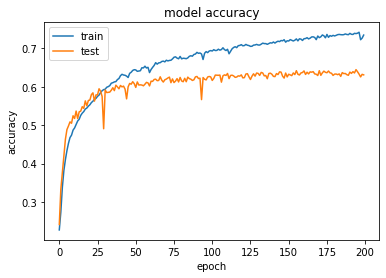

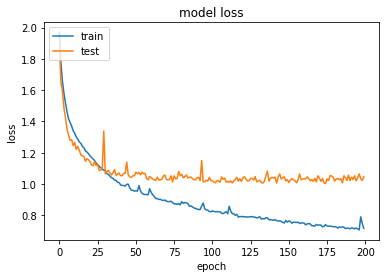

In [ ]:
#Training the model
history=model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1,validation_data=(X_test, y_test), shuffle=True)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Saving the  model to  use it later on
fer_json = model.to_json()
with open("fer1.json", "w") as json_file:
    json_file.write(fer_json)
model.save_weights("fer1.h5")

In [ ]:

score = model.evaluate(X_test, y_test, verbose=1) 
print('Test loss:', score[0])
print('Test accuracy:', score[1]*100)

113/113 [==============================] - 0s 4ms/step - loss: 1.0288 - accuracy: 0.6406
Test loss: 1.0288194417953491
Test accuracy: 64.05683755874634


In [ ]:
import os
import cv2
import numpy as np
from keras.models import model_from_json
from keras.preprocessing import image
from google.colab.patches import cv2_imshow
emotion_dict = {0: "Angry", 1: "Disgusted", 2: "Fearful", 3: "Happy", 4: "Sad", 5: "Surprised", 6: "Neutral"}
emojis = { 0:"\U0001f620",1:"\U0001f922" ,2:"\U0001f628" ,3:"\U0001f60A" , 4:"\U0001f625" ,5:"\U0001f632",6:"\U0001f610" }
print(emojis.values(),sep=" ")

#load model
model = model_from_json(open("/content/drive/MyDrive/Emotion recognition/fer1.json", "r").read())
#load weights
model.load_weights('/content/drive/MyDrive/Emotion recognition/fer1.h5')

def detect(path):
  casc = cv2.CascadeClassifier('/content/drive/MyDrive/Emotion recognition/haarcascade_frontalface_default.xml')
  Path = '/content/drive/MyDrive/Emotion recognition/sad-man-white-background-23197154.jpg'
  image = cv2.imread(Path)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  faces = casc.detectMultiScale(gray,scaleFactor=1.3, minNeighbors=10)
  print("No of faces : ",len(faces))
  i = 1
  for (x, y, w, h) in faces:
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)
    roi_gray = gray[y:y + h, x:x + w]                      #croping
    cropped_img = np.expand_dims(np.expand_dims(cv2.resize(roi_gray, (48, 48)), -1), 0)
    prediction = model.predict(cropped_img)

    maxindex = int(np.argmax(prediction))
    print("person ",i," : ",emotion_dict[maxindex], "-->",emojis[maxindex])
    cv2.putText(image, emotion_dict[maxindex], (x+10, y-20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2) 
    i=i+1 
  
  cv2_imshow(image)

dict_values(['😠', '🤢', '😨', '😊', '😥', '😲', '😐'])


No of faces :  1
person  1  :  Sad --> 😥


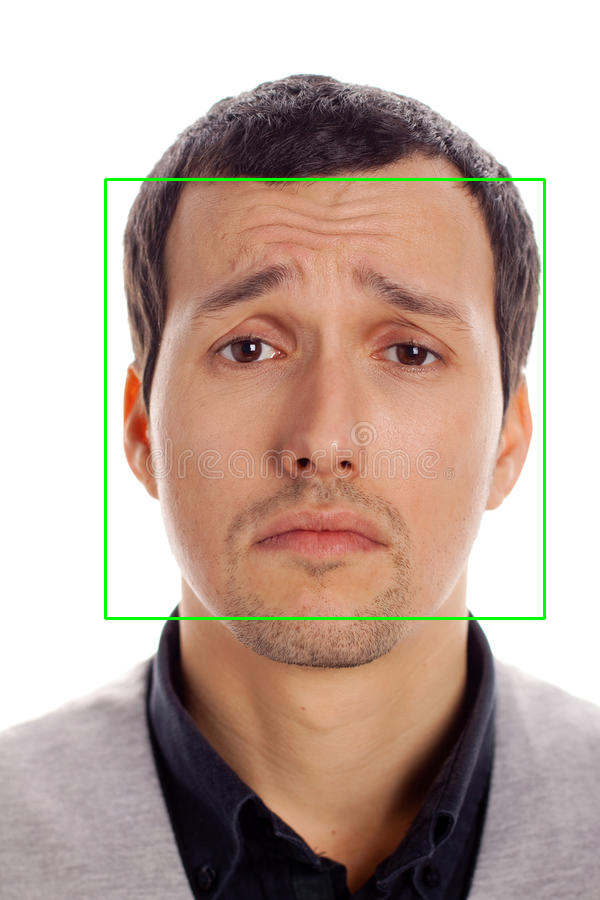

In [ ]:
detect("/content/drive/MyDrive/Emotion recognition/sad-man-white-background-23197154.jpg")

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))